In [1]:
#!pip install --upgrade oct2py
import numpy as np
import pandas as pd
from oct2py import octave
import matplotlib.pyplot as plt
import os
from scipy.optimize import root
import pickle
octave.addpath('C:/dynare/6.1/matlab') 
from IPython.display import display
#octave.addpath('/opt/homebrew/opt/dynare/lib/dynare/matlab')

    _pyeval at line 57 column 30

    _pyeval at line 57 column 30



Writes a line of code to a file that will be used in the call to dynare. 

In [2]:
with open('t_call.m', 'w') as file:
    file.write("stoch_simul(nograph, order=1, periods=1000, irf=100);")

Look through these files. All are run here to update parameters and the model. 

In [3]:
%run make_model.ipynb
%run make_files_1.ipynb
%run make_files_2.ipynb

alpha,beta,delta,sigma_a_0,rho_0,a_0,om_0,om_1,om_2,eps,a_0s,a_1s,a_2s,a_0g,a_1g,a_2g = 0.33,0.975,0.05,0.01,0.95,0,0.5,0.7,0.9,0.5,1,0.5,6,0.0,0.001,0.002
 message: The solution converged.
 success: True
  status: 1
     fun: [-2.025e-11  3.178e-11  2.958e-11 -2.173e-12]
       x: [ 7.256e-01  4.795e-01  4.506e-01  2.199e+00]
    nfev: 23
    fjac: [[-6.714e-01 -6.993e-01 -1.921e-01  1.527e-01]
           [ 6.515e-01 -6.936e-01  3.003e-01  6.619e-02]
           [ 3.296e-01 -1.063e-01 -9.181e-01 -1.926e-01]
           [-1.271e-01 -1.367e-01  1.731e-01 -9.671e-01]]
       r: [-1.871e+00  5.562e-01  8.802e-01  1.442e-01  7.360e-01
            3.913e-01 -1.906e-01  9.562e-01 -2.765e-01 -8.173e-02]
     qtf: [-4.304e-10 -7.289e-10 -1.001e-09  1.367e-10]


In [4]:
#a=octave.addpath(os.path.expanduser('C:/Users/blankenw/GitHub/dynare_progs/np_1'))

Makes a call to Octave, which makes a call to Dynare. Then the `.mod` file is run in Dynare. Output from Dynare is displayed as it runs. It is helpful to look at model_1.mod. It consolidates the files we have written into the various blocks needed by dynare. 

In [5]:

octave.dynare('model_1.mod')





Starting Dynare (version 6.1).
Calling Dynare with arguments: none
Starting preprocessing of the model file ...
Found 5 equation(s).
Evaluating expressions...
Computing static model derivatives (order 1).
Normalizing the static model...
Finding the optimal block decomposition of the static model...
2 block(s) found:
  1 recursive block(s) and 1 simultaneous block(s).
  the largest simultaneous block has 4 equation(s)
                                 and 4 feedback variable(s).
Computing dynamic model derivatives (order 1).
Normalizing the dynamic model...
Finding the optimal block decomposition of the dynamic model...
2 block(s) found:
  1 recursive block(s) and 1 simultaneous block(s).
  the largest simultaneous block has 4 equation(s)
                                 and 4 feedback variable(s).
Preprocessing completed.
Preprocessing time: 0h00m00s.

STEADY-STATE RESULTS:

y   		 0.150092
c   		 -0.34066
i   		 0.450641
k   		 2.19865
a_0 		 0

EIGENVALUES:
         Modulus           

{'time': {'preprocessor': 0.4346330165863037, 'compute': 0.5961871147155762}}

Dynare creates some `structure`s which we will need so we `pull` them from Octave. These are called `oo_` and `M_` This brings `oo_` in as `oo` and `M_` as `mm`. We mostly use oo_.

In [6]:
oo = octave.pull('oo_')
mm = octave.pull('M_')
print(type(mm))
print(type(oo))

    _pyeval at line 28 column 9

    _pyeval at line 28 column 9

<class 'oct2py.io.Struct'>
<class 'oct2py.io.Struct'>


`oo` is of type `oct2py.io.Struct` which we cannot easily deal with in this form. The goal of the next cells it to convert all the parts we need into familiar data types. First we get the names of all the attributes that are specific to `oo`.

In [7]:
names1 = [attr for attr in dir(oo) if not attr.startswith('__')]

Now we want to create a class where each each attribute in oo becomes an attribute of this class. So far we take only one item from mm. This is a list of endogenous variables. Below we define the class. 

In [8]:
class from_octave:
	def __init__(self, oo_structure, mm_structure, attribute_names):
		self.oo_structure = oo_structure
		self.mm_structure = mm_structure
		self. attribute_names =  attribute_names
		self.create_attributes()
		self.make_list()
     
	def create_attributes(self): 
		for attr in self.attribute_names:
			setattr(self, attr, getattr(self.oo_structure, attr)) #this is the attributes we pull from the oo structure. We are making them attributes of the class
	
	def make_list(self): 
		self.names = list(getattr(self.mm_structure, 'endo_names')) #getting one item from the mm structure. This is the endo_names
		self.names = [item[0] for item in self.names] #pulling mm gives us a list of cell arrays. We are pulling the first item from each cell array

Now we create an instance of this class using `oo` as the `oo_structure`, `mm` as `mm_structure` and `names1` as the `attributes_names`.

In [9]:
tt = from_octave(oo, mm, names1)

We see that we now can reference any of the data from `oo` with the `tt.` notation. Some examples are below. 

In [10]:
#names1

In [11]:
#mm

In [12]:
tt.var

array([[0.0012684 , 0.00126594, 0.00057334, 0.00067555, 0.00131451],
       [0.00126594, 0.00131423, 0.00053614, 0.00076369, 0.00131807],
       [0.00057334, 0.00053614, 0.00028483, 0.00024173, 0.00058984],
       [0.00067555, 0.00076369, 0.00024173, 0.00051751, 0.00071087],
       [0.00131451, 0.00131807, 0.00058984, 0.00071087, 0.00136304]])

In [13]:
tt.steady_state

array([[ 0.15009227],
       [-0.34065995],
       [ 0.45064079],
       [ 2.19864754],
       [ 0.        ]])

In [14]:
tt.irfs

{'y_a_0_shock': array([[9.95188408e-03, 9.41074880e-03, 8.90081015e-03, 8.42011468e-03,
         7.96684403e-03, 7.53930464e-03, 7.13591828e-03, 6.75521334e-03,
         6.39581690e-03, 6.05644741e-03, 5.73590791e-03, 5.43307993e-03,
         5.14691771e-03, 4.87644304e-03, 4.62074038e-03, 4.37895244e-03,
         4.15027609e-03, 3.93395857e-03, 3.72929397e-03, 3.53562006e-03,
         3.35231530e-03, 3.17879606e-03, 3.01451407e-03, 2.85895412e-03,
         2.71163180e-03, 2.57209153e-03, 2.43990467e-03, 2.31466775e-03,
         2.19600089e-03, 2.08354629e-03, 1.97696682e-03, 1.87594471e-03,
         1.78018039e-03, 1.68939131e-03, 1.60331094e-03, 1.52168774e-03,
         1.44428429e-03, 1.37087643e-03, 1.30125245e-03, 1.23521237e-03,
         1.17256724e-03, 1.11313846e-03, 1.05675722e-03, 1.00326391e-03,
         9.52507586e-04, 9.04345472e-04, 8.58642497e-04, 8.15270851e-04,
         7.74109576e-04, 7.35044182e-04, 6.97966277e-04, 6.62773235e-04,
         6.29367868e-04, 5.97658127e

In [15]:
tt.names

['y', 'c', 'i', 'k', 'a_0']

We will care about the irfs but these are also of type `oct2py.io.Struct`. We convert it as above. We will likley make this part of the above class later, but for now we create a new class. 

In [16]:
names2 = [attr for attr in dir(tt.irfs) if attr.endswith('shock')]
names2 = [x for _, x in sorted(zip(tt.names, names2), key=lambda pair: pair[0][0])]

In [17]:
names2

['y_a_0_shock', 'c_a_0_shock', 'i_a_0_shock', 'k_a_0_shock', 'a_0_a_0_shock']

I will put more desciptors here later. However, it is getting the impulse responses as difference and levels. It is simultanosuly creating two dataframes containing all differences and levels data.  

In [18]:
import numpy as np

class make_irfs:
	def __init__(self, dta, ss, names):
		self.data = dta
		self.ss = ss
		self.names = names
		self.create_difs()
		self.make_levels()
  	
	def create_difs(self):
		self.df_dif = pd.DataFrame()  # Initialize an empty DataFrame
		for attr in self.names:
			new_attr = attr.replace('_a_0_shock', '')
			new_attr = new_attr + 'dif'
			flattened_attr = np.array(getattr(self.data, attr)).flatten()
			setattr(self, new_attr, flattened_attr)
			self.df_dif[new_attr] = flattened_attr
   
	def make_levels(self):
		self.df = pd.DataFrame()  # Initialize an empty DataFrame
		for j,attr in enumerate(self.names):
			new_attr = attr.replace('_a_0_shock', '')
			raw_level = np.array(getattr(self.data, attr)).flatten()
			ss_value=self.ss[j]
			if new_attr != 'i':
				current_level=np.exp(raw_level+ss_value)
			else:
				current_level=raw_level+ss_value
			setattr(self, new_attr, current_level)
    
			self.df[new_attr] = current_level
  





Define an instance.

In [19]:
ir = make_irfs(tt.irfs,tt.steady_state, names2)
print(ir.__dict__.keys())

dict_keys(['data', 'ss', 'names', 'df_dif', 'ydif', 'cdif', 'idif', 'kdif', 'a_0dif', 'df', 'y', 'c', 'i', 'k', 'a_0'])


Lets get a sense of what we have. 

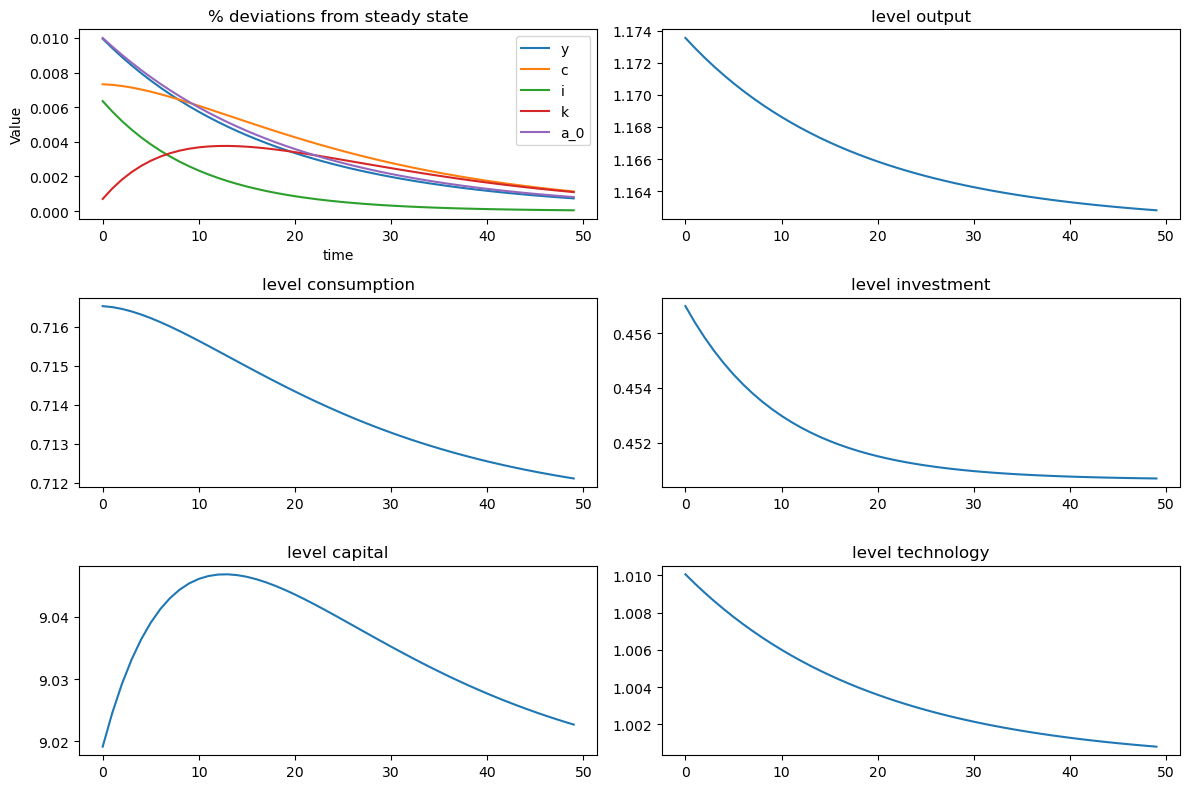

In [20]:
tm=50
# Create a figure and two subplots in the same row
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(12, 8))

# Plot tot, sc, and wi on the first subplot
ax1.plot(ir.ydif[0:tm], label='y')
ax1.plot(ir.cdif[0:tm], label='c')
ax1.plot(ir.idif[0:tm], label='i')
ax1.plot(ir.kdif[0:tm], label='k')
ax1.plot(ir.a_0dif[0:tm], label='a_0')
ax1.legend()
ax1.set_xlabel('time')
ax1.set_ylabel('Value')
ax1.set_title('% deviations from steady state')
ax2.set_title('level output')
ax2.plot(ir.y[0:tm], label='y')
ax3.set_title('level consumption')
ax3.plot(ir.c[0:tm], label='c')
ax4.set_title('level investment')
ax4.plot(ir.i[0:tm], label='i')
ax5.set_title('level capital')
ax5.plot(ir.k[0:tm], label='k')
ax6.set_title('level technology')
ax6.plot(ir.a_0[0:tm], label='a_0')
plt.tight_layout()
plt.show()


In [21]:
ir.df_dif

,ydif,cdif,idif,kdif,a_0dif
0,0.009952,0.007326,6.352526e-03,0.000705,0.010000
1,0.009411,0.007291,5.748532e-03,0.001307,0.009500
2,0.008901,0.007227,5.201964e-03,0.001819,0.009025
3,0.008420,0.007137,4.707365e-03,0.002251,0.008574
4,0.007967,0.007025,4.259791e-03,0.002611,0.008145
...,...,...,...,...,...
95,0.000069,0.000112,4.796668e-07,0.000113,0.000077
96,0.000065,0.000106,4.340603e-07,0.000107,0.000073
97,0.000062,0.000101,3.927901e-07,0.000102,0.000069
98,0.000059,0.000096,3.554439e-07,0.000097,0.000066


In [22]:
ir.df

,y,c,i,k,a_0
0,1.173563,0.716531,0.456993,9.019171,1.010050
1,1.172928,0.716506,0.456389,9.024607,1.009545
2,1.172330,0.716460,0.455843,9.029227,1.009066
3,1.171766,0.716395,0.455348,9.033122,1.008611
4,1.171235,0.716316,0.454901,9.036376,1.008178
...,...,...,...,...,...
95,1.162021,0.711380,0.450641,9.013831,1.000077
96,1.162017,0.711376,0.450641,9.013780,1.000073
97,1.162014,0.711373,0.450641,9.013732,1.000069
98,1.162010,0.711369,0.450641,9.013687,1.000066


This will also need more documentation, but it is getting the results of dynare's simulation. It defines the individual series and also puts all in a dataframe. 

In [23]:
import numpy as np

class make_data:
	def __init__(self, dta,names):
		self.data = dta
		self.names = names
		self.make_levels()

  		
	def make_levels(self):
		self.df = pd.DataFrame()  # Initialize an empty DataFrame
		for j,attr in enumerate(self.names):
			attr=self.names[j]
			raw_level = self.data[j]
			#ss_value=self.ss[j]
			if attr != 'i':
				current_level=np.exp(raw_level)
			else:
				current_level=raw_level
			setattr(self, attr, current_level)
			self.df[attr] = current_level  # Store in DataFrame



Define an instance. 

In [24]:
eg=make_data(tt.endo_simul,tt.names)

In [25]:
eg.df

,y,c,i,k,a_0
0,1.147864,0.704947,0.442860,9.005038,0.987826
1,1.157390,0.708933,0.448452,9.003240,0.996010
2,1.152817,0.706797,0.445998,8.999082,0.992044
3,1.159115,0.709468,0.449645,8.998775,0.997461
4,1.165944,0.712531,0.453408,9.002240,1.003365
...,...,...,...,...,...
995,1.119048,0.700869,0.417445,9.195850,0.964407
996,1.104851,0.692547,0.411105,9.146402,0.951822
997,1.110066,0.693022,0.416089,9.104705,0.956016
998,1.109729,0.691236,0.417572,9.066760,0.955454


In [26]:

v_c = eg.df.cov()

# Print the variance-covariance matrix
print(v_c)

            y         c         i         k       a_0
y    0.001636  0.000998  0.000638  0.006762  0.001459
c    0.000998  0.000633  0.000365  0.004662  0.000894
i    0.000638  0.000365  0.000272  0.002105  0.000565
k    0.006762  0.004662  0.002105  0.040049  0.006119
a_0  0.001459  0.000894  0.000565  0.006119  0.001301


In [27]:
eg.df['y']

0      1.147864
1      1.157390
2      1.152817
3      1.159115
4      1.165944
         ...   
995    1.119048
996    1.104851
997    1.110066
998    1.109729
999    1.121564
Name: y, Length: 1000, dtype: float64

In [28]:
%run par_list.m

We have only solve for y, c, i, and k. But we have all other items as functions of these as seen in review_2. The rest of this defines some of them and gives examples of how we might deal with the simulated data. 

In [29]:
y=eg.y
a_0=eg.a_0
c=eg.c
i=eg.i


These are all things from our document. 

In [30]:
length = len(eg.y)
#a_0=a_0s*(1+a_0g)** np.arange(length)
a_1=a_1s*(1+a_1g)** np.arange(length)
a_2=a_2s*(1+a_2g)** np.arange(length)
x_0=np.ones(length)
x_1=(om_1/om_0)**eps*(a_0/a_1)**(1-eps)
x_2=(om_2/om_0)**eps*(a_0/a_2)**(1-eps)
xb=x_0+x_1+x_2
p_0=np.ones(length)
p_1=a_0/a_1
p_2=a_0/a_2
c_0=c/xb
c_1=x_1/xb*p_0/p_1*c
c_2=x_2/xb*p_0/p_2*c
y_0=c_0+i
py_0=p_0*y_0
py_1=p_1*c_1
py_2=p_2*c_2
n_0=1-1/xb*c/y*(x_1+x_2)
n_1=x_1/xb*c/y
n_2=x_2/xb*c/y
n_0grow = (n_0 - np.roll(n_0, 1)) / np.roll(n_0, 1)
n_0grow[0] = np.nan 
n_1grow = (n_1 - np.roll(n_1, 1)) / np.roll(n_1, 1)
n_1grow[0] = np.nan 
n_2grow = (n_2 - np.roll(n_2, 1)) / np.roll(n_2, 1)
n_2grow[0] = np.nan 


As an example, I add some to our dataframe. 

In [31]:
add_cols={
'c_0':c_0,
'c_1':c_1,   
'c_2':c_2, 
'py_0':py_0,
'py_1':py_1,   
'py_2':py_2, 
'n_0':n_0,
'n_1':n_1,   
'n_2':n_2, 
}

In [32]:
eg.df = eg.df.assign(**add_cols)

In [33]:
ir.df

,y,c,i,k,a_0
0,1.173563,0.716531,0.456993,9.019171,1.010050
1,1.172928,0.716506,0.456389,9.024607,1.009545
2,1.172330,0.716460,0.455843,9.029227,1.009066
3,1.171766,0.716395,0.455348,9.033122,1.008611
4,1.171235,0.716316,0.454901,9.036376,1.008178
...,...,...,...,...,...
95,1.162021,0.711380,0.450641,9.013831,1.000077
96,1.162017,0.711376,0.450641,9.013780,1.000073
97,1.162014,0.711373,0.450641,9.013732,1.000069
98,1.162010,0.711369,0.450641,9.013687,1.000066


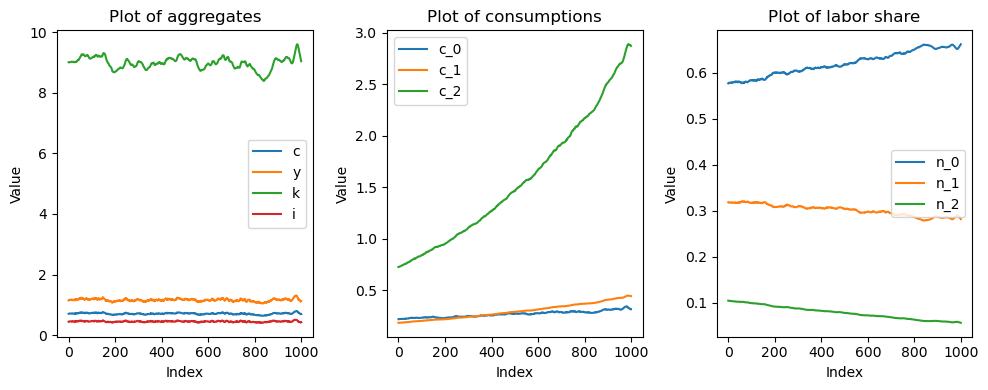

In [34]:


fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10, 4))

eg.df[['c','y', 'k', 'i']].plot(ax=ax1)
ax1.set_title('Plot of aggregates')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')



eg.df[['c_0', 'c_1', 'c_2']].plot(ax=ax2)
ax2.set_title('Plot of consumptions')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')

# Plot columns 'd', 'e', 'f' on the second axis
eg.df[['n_0', 'n_1', 'n_2']].plot(ax=ax3)
ax3.set_title('Plot of labor share')
ax3.set_xlabel('Index')
ax3.set_ylabel('Value')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [35]:
check1=y-(py_0+py_1+py_2)
print(np.max(np.abs(check1)))
check2=1-(n_0+n_1+n_2)
print(np.max(np.abs(check2)))

check3=(n_1grow-n_2grow)-((1-eps)*(a_1g-a_2g))
print(np.nanmax(np.abs(check3)))

0.00348439731250072
2.220446049250313e-16
0.0010015762428326673


In [36]:
df_cov=eg.df[['y','c','c_0','n_0']].cov()

In [37]:

# Function to highlight the diagonal
def highlight_diagonal(data):
	attr = 'background-color: yellow'
	# Create a DataFrame with empty strings
	df_styler = pd.DataFrame('', index=data.index, columns=data.columns)
	# Set the diagonal to the desired attribute
	np.fill_diagonal(df_styler.values, attr)
	return df_styler

# Apply the function to the DataFrame
df_cov = df_cov.style.apply(highlight_diagonal, axis=None)

# Display the styled DataFrame
df_cov

,y,c,c_0,n_0
y,0.001636,0.000998,0.000129,-0.000231
c,0.000998,0.000633,0.000073,-0.000167
c_0,0.000129,0.000073,0.000836,0.000694
n_0,-0.000231,-0.000167,0.000694,0.000666
